# CONTROLLER EXAMPLES

This notebook summarizes modeling with Antimony and constructing a PID controller.

# Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te

# Antimony and Tellurium Basics

Antimony is a language for modeling chemical systems that allows the modeller to describe how species are transformed into other species by reactions.

A reaction has:
* a left hand side that specifies reactants
* a right hand side that specifies products
* a rate law that is a mathematical expression of the rate (flux) of the reaction

For example:

    J1: A + B -> C + D; k*A*B
    
    k = 2

``J1`` is the name of a reaction that transforms species ``A`` and ``B`` into ``C`` and ``D`` at a rate that is k times the current concentration of ``A`` and ``B``.

# Uncontrolled Sequential Pathway

We are given a sequential pathway that is fed by the boundary species $S_1$. The input $S_1$ is corrupted by a sinusoidal disturbance at time 10. How to do regulate the pathway to ensure that the output is 5?

$S_1 \xrightarrow{k_1 S_1} S_2 \xrightarrow{k_2 S_2} S_3 \xrightarrow{k_3 S_3} \emptyset,~~ k_1 = 1, k_2 =2, k_3=0.5$

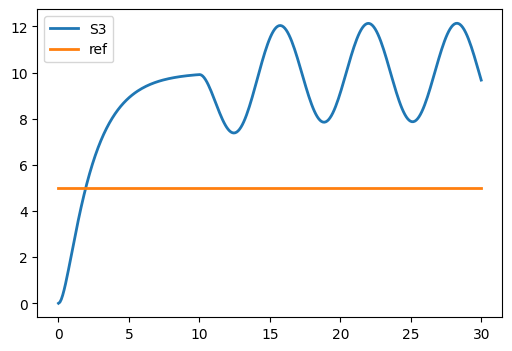

In [2]:
model = """
S1 -> S2; k1*(S1 + delta*sin(time))
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>10: delta = delta + normal(3, 1);
"""
rr = te.loada(model)
rr.simulate(0, 30, 300, selections=["time", "S3", "ref"]) # Simulate the interval [0, 10] with 100 points
rr.plot()

**Observations**
1. Very limited ability to control the output.

1. Antimony model
2. Tellurium with plots
3. Regulating the output

# Proportional Controller

We insert an external controller that regulates $S_1$ instead of maintaining it at a fixed value. The design problem is to select thee appropriate value of $k_P$, the constant for the proportional controller.

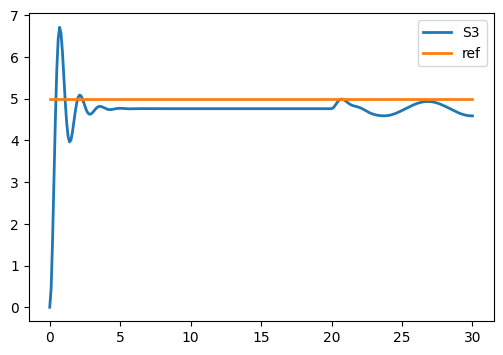

In [3]:
model = """
const S1;

S1 -> S2; k1*(S1 + delta*sin(time))
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>20: delta = delta + normal(3, 1);

// Proportional controller
kP = 10;
error := ref - S3
S1 := kP*error
"""
rr = te.loada(model)
rr.simulate(0, 30, 300, selections=["time", "S3", "ref"]) # Simulate the interval [0, 10] with 100 points
rr.plot()

**Observations about Proportional Control**
* Appeal
    1. Can automatically find the right input to match the output.
    2. Can adjust to random fluctuations
* Issues
    1. Does not achieve reference (**bias**)
    2. Lower bias with larger gain ($k_P$), but also get (**overshoot** and **oscillations**)

# Proportional Integral Controller

We change to an propportional integral (PI) controller to take into account more history.

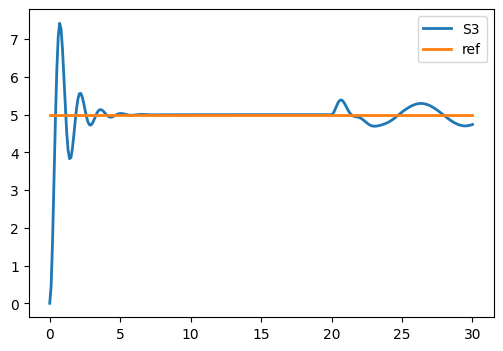

In [17]:
model = """
const S1;

S1 -> S2; k1*(S1 + delta*sin(time))
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>20: delta = delta + normal(3, 1);

// Proportional controller
kP = 10;
kI = 5
error := ref - S3
integral_error = 0
integral_error' = error
S1 := kP*error + kI*integral_error
"""
rr = te.loada(model)
rr.simulate(0, 30, 300, selections=["time", "S3", "ref"]) # Simulate the interval [0, 10] with 100 points
rr.plot()

**Observations on PI Controller**
* Pro
    1. Eliminates bias
* Con
    1. Complicated to set $k_P$, $k_I$ since two parameters
    2. Can go unstable in unexpected ways (e.g., *decreasing* $k_P$ to 1)

# Proportional Integral Differential Controller

We consider a still more sophisticated controller that tries to anticipate changes in control error.

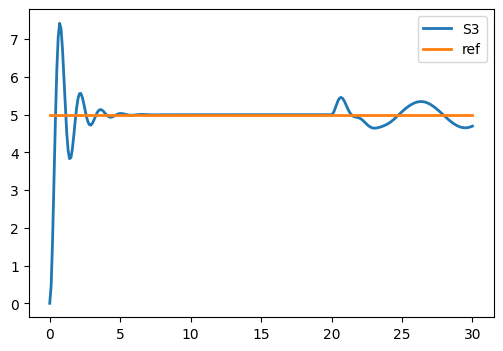

In [15]:
model = """
const S1;

S1 -> S2; k1*(S1 + delta*sin(time))
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>20: delta = delta + normal(3, 1);

// Proportional controller
kP = 10;
kI = 5
kD = 10000
error := ref - S3
integral_error = 0
integral_error' = error
differential_error = -rateOf(S3)
S1 := kP*error + kI*integral_error + kD*differential_error
"""
rr = te.loada(model)
rr.simulate(0, 30, 300, selections=["time", "S3", "ref"]) # Simulate the interval [0, 10] with 100 points
rr.plot()

**Observations**
* Pro
    1. Can address oscillations
* Con
    1. Very complicated to tune
    2. Oscillates and goes unstable in complicated ways